<a href="https://colab.research.google.com/github/MikhailIurkus/yandex_practicum_project/blob/main/yurkus_mihail_issledovanie_nadyozhnosti_zayomshchikov_proekt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование надежности заемщиков.

### Шаг 1. Обзор данных

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.read_csv('/datasets/data.csv')

In [ ]:
display(df.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Шаг 2.1 Заполнение пропусков

* Посмотрю информацию о таблице

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
None


* Проверю наименование столбцов

In [ ]:
print(df.columns)

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')


Все хорошо

* Посмотрю на пропуски

In [ ]:
print(df.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


пропущенные значения в столбцах **days_employed** (но о них мы поговорим позже) и в **total_income**.

Это вещественные числа типа float64 

In [ ]:
# количество пропусков в столбце
missing_values_total_income = df['total_income'].isna().sum() 
missing_values_days_employed = df['days_employed'].isna().sum()

# общее колличество строк
total_lines = df['total_income'].shape[0]

# доля пропущенных значений в total_income
fraction_missing_values_total_income = missing_values_total_income / total_lines

# доля пропущенных значений в days_employed
fraction_missing_values_days_employed = missing_values_days_employed / total_lines

print('Доля прощенных значений равна в столбце total_income {0:.0%}'.format(fraction_missing_values_total_income))
print('Доля прощенных значений равна в столбце days_employed {0:.0%}'.format(fraction_missing_values_days_employed))

Доля прощенных значений равна в столбце total_income 10%
Доля прощенных значений равна в столбце days_employed 10%


### Шаг 2.2 Проверка данных на аномалии и исправления.

Столбцы в которых не хватает данных:

* days_employed — общий трудовой стаж в днях

* total_income — ежемесячный доход

Есть гипотеза:

- кто не имеет стажа - тот не имеет дохода

Проверка:

Сохраню в отдельную таблицу эти столбцы и отфильтрую пустые строчки. 
Если пропуски будут в одних и тех же местах, то гипотеза подтвердится.


In [ ]:
employed_and_income = df.loc[:, ['days_employed', 'total_income']]

display(
    employed_and_income[
                        employed_and_income['days_employed'].isna()
                        ]
        )

,days_employed,total_income
12,NaN,NaN
26,NaN,NaN
29,NaN,NaN
41,NaN,NaN
55,NaN,NaN
...,...,...
21489,NaN,NaN
21495,NaN,NaN
21497,NaN,NaN
21502,NaN,NaN


Моя гипотеза подтверждается

Мы видим, что в 2174 строках пропущены значения в столбцах days_employed и total_income

У кого нет стажа - нет дохода

Медианные значения - является правильным решением для заполнения пропущенных значений, так как мы отсортируем всю колонку с доходами и возьмем данные из ее середины  ⇒ получим болле объективные результаты

## Заполняем пропущенные значения в столбце total_income медианными значениями

In [ ]:
df['total_income'] = df['total_income'].fillna(
    df.groupby(['income_type'])
    ['total_income'].transform('median')
    )

## столбец days_employed

отрицательные значения - это ошибка. Стаж не может быть с минусом. Возможно что то не так с передачей данных или не правильно заполняется форма человеком.
исправлю с помощью abs и посмотрю карту распределения

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

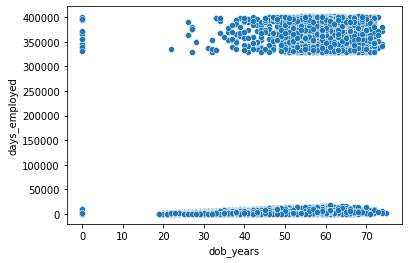

In [ ]:
df['days_employed'] = df['days_employed'].abs()

sns.scatterplot(data=df, x='dob_years', y='days_employed')

In [ ]:
years =  df.loc[:, ['days_employed', 'dob_years']]

years['years_employed'] = (years['days_employed'] / 365)
years['ratio'] = years['years_employed'] / years['dob_years']

anom = 3511 # количество аномалий
propusk = 2174 # количство NaN
gen_str = 21524 # общее количество строк 

for i in years['ratio']:
  if i >= 1:
    anom += 1
print('Доля битых значений в столбце years_employed = {0:.0%}'.format(((anom + propusk)/gen_str)), 'Это очень много.')

Доля битых значений в столбце years_employed = 43% Это очень много.


Есть гипотеза:

Что то случилось с точкой в столбце и ее нужно переместить на два знака влево. 

Звучит бредово, но лучшее идеи у меня нет

гипотеза с переводом часы или минуты не рабочая

In [ ]:
# years['ratio'].loc[:3] = years['ratio'].loc[:3].astype('str') # для проверки try - except

total_errors = 0

for i in years['ratio']:
  try:
    if i >= 1:
      total_errors += 1
      years['ratio'] = years['ratio'].replace(i,i / 100)
      
  except:
    print('Ты хочешь невозможного! Проверь тип данных')

print('Строк с ошибками:', total_errors)

Строк с ошибками: 3519


In [ ]:
years['years_employed'] = years['dob_years'] * years['ratio']

df['days_employed'] = years['years_employed'] * 365

df['days_employed'] = df['days_employed'].fillna(
    df.groupby(['dob_years'])
    ['days_employed'].transform('median')
    )

propuski = df.isna().sum()

propuski = 101 

print('Доля битых значений в столбце years_employed = {0:.0%}'.format((propuski / gen_str)))
display(df.head())
print(df.isna().sum())

Доля битых значений в столбце years_employed = 0%


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,3402.660720,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


children              0
days_employed       101
dob_years             0
education             0
education_id          0
family_status         0
family_status_id      0
gender                0
income_type           0
debt                  0
total_income          0
purpose               0
dtype: int64


<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

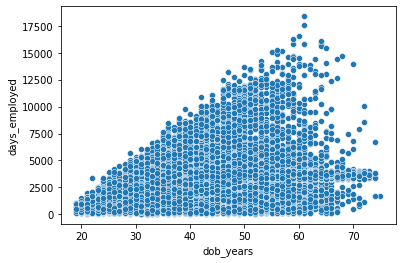

In [ ]:
sns.scatterplot(data=df, x='dob_years', y='days_employed')

красиво

Думаю, что ошибка в столбце days_employed имеет ошибки которые совершены не  из-за человеческого фактора, а и из-за технической ошибки, **а в дальнейшем исследовании этот столбец не учавствует**, я принял решение не просто сразу заменить все пропуски на медианные начения


При замене на медиану я группирую столбцы с возрастом.

Так как в столбце dob_years присутствуют значения = 0, то часть данных при медиане заменилась на 0 в столбце days_employed.

Это не соответствует условию задачи, но так будет правильнее. 

Я продолжу работу с df с 0ми значениями, так как их доля стркмится к 0%

Если потребуется полностью убрать все пропуски, то можно использовать вот этот код:

In [ ]:
# df['days_employed'] = df['days_employed'].fillna(
#     df.groupby(['income_type']) # заменил столбец группировки
#     ['days_employed'].transform('median')
#     )

### Шаг 2.3. Изменение типов данных.

In [ ]:
df['total_income'] = df['total_income'].astype('int')

### Шаг 2.4. Удаление дубликатов.

Все дубликаты в df:

In [ ]:
df.duplicated().sum()

54

Удаление явных дубликатов с перезаписью значений индекса строк (что бы отсутствовали пропуски 1, 2, 3, 5, и тд)

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

Неявные дубли

In [ ]:
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [ ]:
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Еще раз проверю и удалю явные дубликаты:

In [ ]:
print(df.duplicated().sum())

df = df.drop_duplicates().reset_index(drop=True)

print(df.duplicated().sum())

17
0


после того, как я увидел дубликаты в столбце education, я решил для начала привести все строки к одному регистру. после повторной проверки оказалось, что дубликаты пропали.
Проверив остальные столбцы в которых могут встретиться подобные дубликаты я нашел их только в столбце purpose, но не стал их кластеризовать, так как меня об этом не просили. Но я могу.

считаю, что причина - человеческий фактор

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [ ]:
education = df[['education_id', 'education']]
family_status = df[['family_status_id', 'family_status']]

### Шаг 2.6. Категоризация дохода.

In [ ]:
def total_income_category(row):
  income = row['total_income']

  if income <= 30000:
    return 'E'

  if 30001 <= income <= 50000:
    return 'D'

  if 50001 <= income <= 200000:
    return 'C'

  if 200001 <= income <= 1000000:
    return 'B'

  if 1000001 <= income:
    return 'A'

  return 'категория дохода не определена'

#### Проверка функции

In [ ]:
row_values = [99999]
row_columns = ['total_income']

row = pd.Series(data=row_values, index=row_columns)  

total_income_category(row)

'C'

### Шаг 2.7. Категоризация целей кредита.

In [ ]:
def purpose_category(row):
  
  purpose = row['purpose']

  if 'авто' in purpose:
    return 'операции с автомобилем'

  if 'жил' in purpose or 'недвиж' in purpose:
    return 'операции с недвижимостью'
    
  if 'образов' in purpose:
    return 'получение образования'
  
  if 'свад' in purpose:
    return 'проведение свадьбы'
  
  return 'цель не определена'

#### Проверка функции

In [ ]:
row_values = ['жилище']
row_columns = ['purpose']

row = pd.Series(data=row_values, index=row_columns)  

purpose_category(row)

'операции с недвижимостью'

добавляем столбцы с результатами работы функции в df

In [ ]:
df['total_income_category'] = df.apply(total_income_category, axis=1)
df['purpose_category'] = df.apply(purpose_category, axis=1)

### Ответы на вопросы.

##### Вопрос 1:

У нас нет в документации нет сведений что из значений считать за возврат кредита, поэтому я буду руководствоваться принципом:
0 = False - задолжености нет
1 = True - задолженность есть

уберу отрицательное значение

In [ ]:
df['children'] = df['children'].abs()

20 детей - скорее всего опечатка. исправлю на 2 (если бы это была не опечатка, мы бы видели планый рост от 0 детей до 20)

AxesSubplot(0.125,0.125;0.775x0.755)


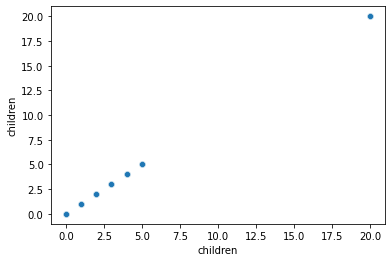

In [ ]:
print(sns.scatterplot(data=df, x='children', y='children'))

AxesSubplot(0.125,0.125;0.775x0.755)


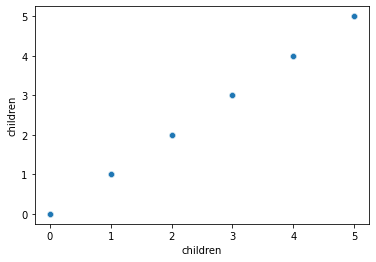

In [ ]:
df['children'] = df['children'].replace(20,2)

print(sns.scatterplot(data=df, x='children', y='children'))

In [ ]:
chidren_pivot = df.pivot_table(
    index=['children'],
    columns='debt',
    values='family_status_id',
    aggfunc='count'
    )

chidren_pivot[1] = chidren_pivot[1].fillna(0) # почикаю NaNы для красоты

chidren_pivot['ratio'] = (chidren_pivot[1] / chidren_pivot[0])*100

chidren_pivot['ratio'] = chidren_pivot['ratio'].round(1).astype(str) + '%'

display(chidren_pivot)

debt,0,1,ratio
children,,,
0,13028.0,1063.0,8.2%
1,4410.0,445.0,10.1%
2,1926.0,202.0,10.5%
3,303.0,27.0,8.9%
4,37.0,4.0,10.8%
5,9.0,0.0,0.0%


##### Вывод 1:

###### Вижу, что у бездетных меньше задолженностей по кредитам.

Однако с появлением одного или двух детей у человека возрастает вероятность того, что задолженность появится.

Это будет происходить пока у заемщика не появится третий ребенок. Должников среди этой категории меньше чем среди тех кто имеет 1го или 2ух детей.

Самый высокий риск появления задолженности у людей которые имеют 4 ребенка.

Если у клиента банка 5 детей, то риск возникновения задолженности сводится к 0. 

(для более точной оценки риска необходимо больше данных людьми которые имеют от 3х до 5ти детей включительно)


##### Вопрос 2:

In [ ]:
family_pivot = family_status.pivot_table(
    index=['family_status'],
    columns=df['debt'],
    values='family_status_id',
    aggfunc='count'
    )

family_pivot['ratio'] = (family_pivot[1] / family_pivot[0]) * 100
family_pivot['ratio'] = family_pivot['ratio'].round(1).astype(str) + '%'


display(family_pivot)

debt,0,1,ratio
family_status,,,
Не женат / не замужем,2536,274,10.8%
в разводе,1110,85,7.7%
вдовец / вдова,896,63,7.0%
гражданский брак,3763,388,10.3%
женат / замужем,11408,931,8.2%


##### Вывод 2:

Сразу вопрос: что мы считаем гражданским браком и что женат/замужем? вот ссыль - https://ru.wikipedia.org/wiki/Гражданский_брак

Вдовцы и люди в разводе имеют наименьший показатель задолженностей

Люди состоящие в гражданском браке (для просты буду считать, что это просто сожительство без регистрации в загсе или церкви) имеют один из самых высоких показательй задолженностей.

Круче гражданских браков только холостые. 10,8% из общего числа заемщиков этой категории доставят хлопоты банку.

Женатые люди - крепкая середина из данной выборки. Имеют задолженность 8,8% семей

Чемпионы люди в разводе. Самый маленький процент долгов - 7,7.

Если вы спросите меня кому дать кредит так, что бы вернул, то я посоветую дать разведенному человеку.

##### Вопрос 3:

Я делал проект в колабе и он там чудесно работает. Но тут происходит какая-то магия и вопрос 3 и 4 выдает ошибку.  Как с этим бороться я не знаю. 

Оставлю ссылку на коллаб https://colab.research.google.com/drive/1LmPo78dE9aANVs5QAzkN1A-YcarV6ngK?usp=sharing

Извините, что так, но тут пробляма с юпитером. он сегодня дико глючит 

In [ ]:
income_pivot = df.pivot_table(
    index='total_income_category',
    columns='debt',
    values='family_status_id',
    aggfunc='count'
    )

income_pivot['sum_debt'] = income_pivot[1] + income_pivot[0]


income_pivot['ratio'] = (income_pivot[1] / income_pivot[0]) * 100
income_pivot['ratio'] = income_pivot['ratio'].round(1).astype(str) + '%'

income_pivot['net_dolga'] = (income_pivot[0]/income_pivot['sum_debt']) * 100
income_pivot['est_dolg'] = (income_pivot[1]/income_pivot['sum_debt']) * 100


income_pivot['sum_debt'] = income_pivot[1] + income_pivot[0]
income_pivot['net_dolga'] = income_pivot['net_dolga'].round(1).astype(str) + '%'
income_pivot['est_dolg'] = income_pivot['est_dolg'].round(1).astype(str) + '%'


income_pivot.sort_values(by='est_dolg',ascending=False) # почему не работает так?

display(income_pivot)

debt,0,1,sum_debt,ratio,net_dolga,est_dolg
total_income_category,,,,,,
A,23,2,25,8.7%,92.0%,8.0%
B,4686,356,5042,7.6%,92.9%,7.1%
C,14655,1360,16015,9.3%,91.5%,8.5%
D,329,21,350,6.4%,94.0%,6.0%
E,20,2,22,10.0%,90.9%,9.1%


##### Вывод 3:

D (доход от 30001 до 50000 денег в месяц) - у этой категрии самый низкий процент задолженностей.

B (доход от 200001 до 1000000 денег в месяц) - если дать кредит 100 человекам из этой группы, то 8 человек скорее всего будут иметь просроченные платежи.

A (доход от 1000001 денег в месяц) - рисковые, но по количеству задолженностей занимают плотную серединку

С (доход от 50001 до 200000 денег в месяц) - люди из этой категории имеют достаточно высокий риск появления задолженностей перед банком

E (доход до 30000 денег в месяц) - люди с низким доходом чаще других не возвращают долг в срок.
Прямой корреляции появления задолженности от уровня дохода аналитик Миша не выявил.

##### Вопрос 4:

In [ ]:
purpose_pivot = df.pivot_table(
    index='purpose_category',
    columns='debt',
    values='family_status_id',
    aggfunc='count'
    )

purpose_pivot['ratio'] = (purpose_pivot[1] / purpose_pivot[0]) * 100
purpose_pivot['ratio'] = purpose_pivot['ratio'].round(1).astype(str) + '%'

display(purpose_pivot)

debt,0,1,ratio
purpose_category,,,
операции с автомобилем,3903,403,10.3%
операции с недвижимостью,10029,782,7.8%
получение образования,3643,370,10.2%
проведение свадьбы,2138,186,8.7%


##### Вывод 4:

Разные цели по разному влияют на возврат кредита в срок. 

Думаю, что для категории людей цель которых операции с автомобилем нужно закладывать риск просорочек больше чем для любых других категорий, так как по статистике 10% таких заемщиков не возвращают кредит в срок.

Меньше всего проблем с возвратом кредита в установленные договором сроки имеют люди которые совершают операции с недвижимостью.

## Общий вывод:

1) Это было эпично и легендарно

2) у меня не получается сортировать( например:

purpose_pivot = purpose_pivot.sort_values(by='ratio', ascending=True)

3) Возможно я перемудрил со сдвигом точки в столбце со стажем, но мне кажется, что график распределения у меня получился красивый

4) Преподаватель по проектам подсказала очень крутой способ считать медиану (в данном случае) с помощью метода trasform. Нравится

5) Спасибо за проверку моей работы)

6) Если потребуется, я напишу выводы в официальном стиле.

<div class="alert alert-info">
<b>Общий вывод:</b>
<br>Портрет клиента с наибольшей вероятностью просрочки по кредиту: имеет 4 ребенка, не состоит в браке, имеет доход до 30 000 рублей в месяц и хочет купить автомобиль.
</div>